In [1]:
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.models as models

In [2]:
df = pd.read_csv("./data_with_labels.csv")

In [3]:
df

,file_path,label,subset
0,test/cats/cat_1.jpg,cats,test
1,test/cats/cat_106.jpg,cats,test
2,test/cats/cat_109.jpg,cats,test
3,test/cats/cat_113.jpg,cats,test
4,test/cats/cat_114.jpg,cats,test
...,...,...,...
692,train/dogs/dog_92.jpg,dogs,train
693,train/dogs/dog_93.jpg,dogs,train
694,train/dogs/dog_97.jpg,dogs,train
695,train/dogs/dog_98.jpg,dogs,train


In [4]:
from PIL import Image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Путь к изображению
        image = Image.open(img_path).convert("RGB")
        label = 1 if self.dataframe.iloc[idx, 1] == 'dogs' else 0  # Метка 'dogs' -> 1, 'cats' -> 0
        
        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Размер, соответствующий EfficientNet-B3
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Размер, соответствующий EfficientNet-B3
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


# Разделение на обучающий и тестовый наборы данных
train_df = df[df['subset'] == 'train']
test_df = df[df['subset'] == 'test']

# Создание наборов данных
train_dataset = CustomImageDataset(train_df, transform=train_transform)
test_dataset = CustomImageDataset(test_df, transform=test_transform)
# Создание DataLoader
batch_size = 8

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
train_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


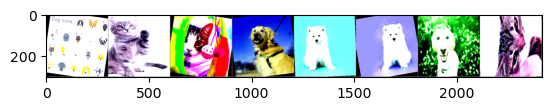

1 0 0 1 1 1 1 0


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Функция для отображения изображений
def imshow(img):
    img = img / 2 + 0.5  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Получить пакет данных из train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Отображение изображений
imshow(torchvision.utils.make_grid(images))

# Печать меток
print(' '.join(f'{labels[j].item()}' for j in range(len(labels))))


In [12]:
model = models.efficientnet_b3(weights=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Функция для вычисления точности
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct

# Функция обучения
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct_train += calculate_accuracy(outputs, labels)
            total_train += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                correct_val += calculate_accuracy(outputs, labels)
                total_val += labels.size(0)
        
        val_loss /= len(test_loader)
        val_accuracy = 100 * correct_val / total_val
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
        
        early_stopping(val_loss)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

# Обучение модели
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5, patience=5)

# Оценка модели на тестовой выборке
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            correct += calculate_accuracy(outputs, labels)
            total += labels.size(0)
    
    print(f'Test Accuracy: {100 * correct / total}%')

# Оценка модели
evaluate_model(model, test_loader)

Epoch 1/5, Training Loss: 0.28680831811257773, Training Accuracy: 87.07360861759426, Validation Loss: 0.29582691228845054, Validation Accuracy: 89.28571428571429
Epoch 2/5, Training Loss: 0.23985843454554145, Training Accuracy: 90.48473967684022, Validation Loss: 0.21549252808714905, Validation Accuracy: 91.42857142857143
Epoch 3/5, Training Loss: 0.2510895924908774, Training Accuracy: 92.10053859964093, Validation Loss: 0.6112841825674372, Validation Accuracy: 89.28571428571429
EarlyStopping counter: 1 out of 5
Epoch 4/5, Training Loss: 0.3390758287161589, Training Accuracy: 88.50987432675045, Validation Loss: 0.6364234640366502, Validation Accuracy: 71.42857142857143
EarlyStopping counter: 2 out of 5
Epoch 5/5, Training Loss: 0.2185380105594439, Training Accuracy: 91.56193895870736, Validation Loss: 0.25305597939425045, Validation Accuracy: 87.85714285714286
EarlyStopping counter: 3 out of 5
Test Accuracy: 87.85714285714286%


In [14]:
# Сохранение модели
torch.save(model.state_dict(), 'model_efficientnet_b3.pth')

